In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [2]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [3]:
gen4 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen4_sims/data")

In [4]:
X5, y5 = format_data(gen4, 20)
print(X5.shape)
print(y5.shape)

(33032, 20, 2)
(33032, 1)


In [5]:
X5_train, y5_train, X5_test, y5_test = split_data(X5, y5, 0.8)

In [6]:
X5_train, y5_train, X5scale, y5scale = normalise_data(X5_train, y5_train)
X5_test, y5_test, _, _ = normalise_data(X5_test, y5_test)

In [7]:
print(X5scale.mean_)
print(X5scale.var_)
print(y5scale.mean_)
print(y5scale.var_)
print(X5_train)
print(y5_train)

[4.59605833 4.79008357]
[0.14824653 0.01544488]
[4.59506378]
[0.16311941]
[[[ 0.02366543 -1.4879078 ]
  [-0.00165052 -1.4798653 ]
  [ 0.01195159 -1.47022491]
  ...
  [ 0.08196299 -1.38318295]
  [ 0.05977425 -1.37921269]
  [ 0.06770234 -1.37127806]]

 [[-0.00165052 -1.4798653 ]
  [ 0.01195159 -1.47022491]
  [ 0.02548285 -1.46059606]
  ...
  [ 0.05977425 -1.37921269]
  [ 0.06770234 -1.37127806]
  [ 0.07382364 -1.36335124]]

 [[ 0.01195159 -1.47022491]
  [ 0.02548285 -1.46059606]
  [ 0.03661914 -1.45258081]
  ...
  [ 0.06770234 -1.37127806]
  [ 0.07382364 -1.36335124]
  [ 0.08906406 -1.35543222]]

 ...

 [[ 0.59385014  0.26113759]
  [ 0.59447565  0.26890325]
  [ 0.59739269  0.27666141]
  ...
  [ 0.61255016  0.3730126 ]
  [ 0.63317126  0.38067108]
  [ 0.61296419  0.38832228]]

 [[ 0.59447565  0.26890325]
  [ 0.59739269  0.27666141]
  [ 0.6166875   0.29860235]
  ...
  [ 0.63317126  0.38067108]
  [ 0.61296419  0.38832228]
  [ 0.63317126  0.37109684]]

 [[ 0.59739269  0.27666141]
  [ 0.616687

In [8]:
lstm5=keras.Sequential() #Set up the architecture of the model

lstm5.add(layers.LSTM(units=16, input_shape=(X5_train.shape[1], X5_train.shape[2])))
lstm5.add(layers.Dropout(0.2))

lstm5.add(layers.Dense(units=1))

In [9]:
print(lstm5.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
lstm5.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history5 = lstm5.fit(X5_train, y5_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 21140 samples, validate on 5285 samples
Epoch 1/10
21140/21140 [==============================] - 41s 2ms/sample - loss: 0.0653 - val_loss: 0.0073
Epoch 2/10
21140/21140 [==============================] - 32s 2ms/sample - loss: 0.0274 - val_loss: 0.0058
Epoch 3/10
21140/21140 [==============================] - 34s 2ms/sample - loss: 0.0242 - val_loss: 0.0031
Epoch 4/10
21140/21140 [==============================] - 31s 1ms/sample - loss: 0.0228 - val_loss: 0.0030
Epoch 5/10
21140/21140 [==============================] - 28s 1ms/sample - loss: 0.0195 - val_loss: 0.0022
Epoch 6/10
21140/21140 [==============================] - 30s 1ms/sample - loss: 0.0191 - val_loss: 0.0045
Epoch 7/10
21140/21140 [==============================] - 26s 1ms/sample - loss: 0.0202 - val_loss: 0.0086
Epoch 8/10
21140/21140 [==============================] - 30s 1ms/sample - loss: 0.0200 - val_loss: 0.0028
Epoch 9/10
21140/21140 [==============================] - 34s 2ms/sample - loss: 0.0186 - val_l

In [12]:
lstm5.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm5/assets


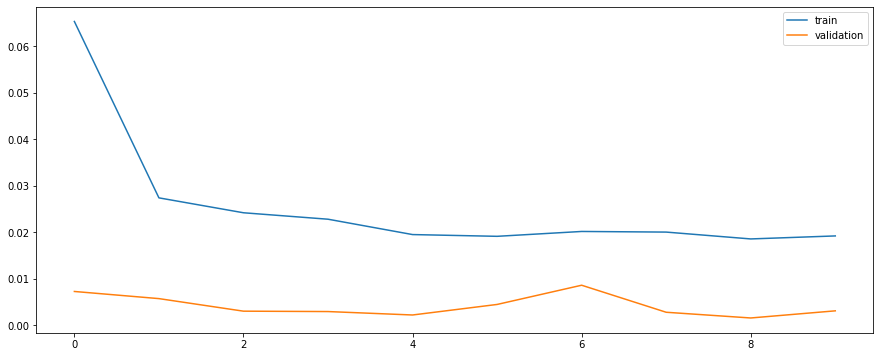

In [13]:
plt.figure(figsize=(15,6))
plt.plot(history5.history["loss"], label="train")
plt.plot(history5.history["val_loss"], label="validation")
plt.legend()

In [14]:
y5_pred = lstm5.predict(X5_test)
y5_train_inv = y5scale.inverse_transform(y5_train.reshape(1, -1))
y5_test_inv = y5scale.inverse_transform(y5_test.reshape(1, -1))
y5_pred_inv  = y5scale.inverse_transform(y5_pred)

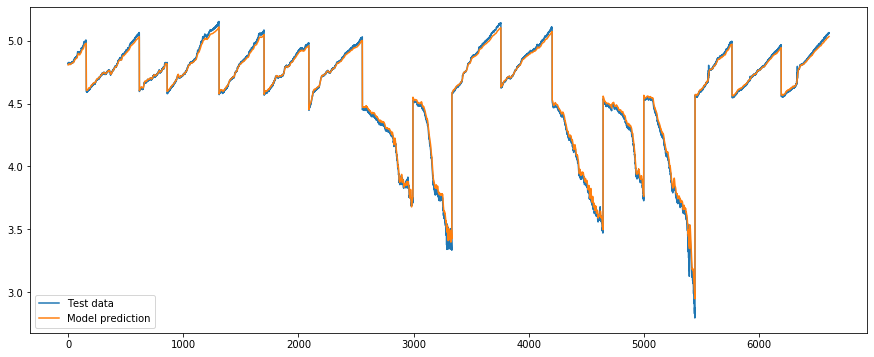

In [15]:
plt.figure(figsize=(15,6))
plt.plot(y5_test_inv.flatten(), label="Test data")
plt.plot(y5_pred_inv.flatten(), label="Model prediction")
plt.legend()